In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import xgboost as xgb
import shap

/Users/timothychung/opt/anaconda3/envs/env1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Student Body diversity

In [3]:
ethnicity = pd.read_csv(
    'IPEDS_Dataset_Encoded/Fall Enrollment/EFA_2015-2020_data.csv', sep=',')


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
invalid value encountered in divide


Text(0, 0.5, 'Count')

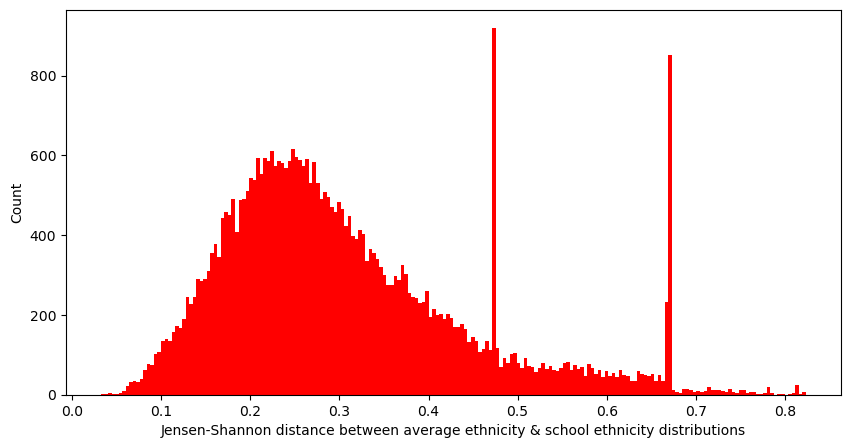

In [5]:
def JSD(b): 
    '''
    Jensen-Shannon distance between two vectors
    '''
    a = overall_ethn
    b = np.array(b, dtype=np.float)
    _M = 0.5 * (a + b)
    return distance.jensenshannon(a,b)

ethn = ethnicity[(ethnicity.efalevel == 'All students total')].set_index('unitid')
ethn.loc[:,'other'] = ethn[['ef2mort',"efunknt","efunknt"]].sum(axis=1)

data_ethn = ethn[['efaiant','efasiat','efbkaat','efhispt','efnhpit','efwhitt','other']].div(ethn['eftotlt'], axis=0)
overall_ethn = np.array(data_ethn.mean())


data_ethn['kl_distance'] = data_ethn.apply(lambda x: JSD(np.array(x)), axis=1)
data_ethn['kl_distance'] = data_ethn['kl_distance'].apply(lambda x: 10 if x==np.inf else x)

fig, ax  = plt.subplots(figsize=(10,5))
data_ethn['kl_distance'].hist(bins=200, color='r').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Jensen-Shannon distance between average ethnicity & school ethnicity distributions')
ax.set_ylabel('Count')

## 2. Graduation rate

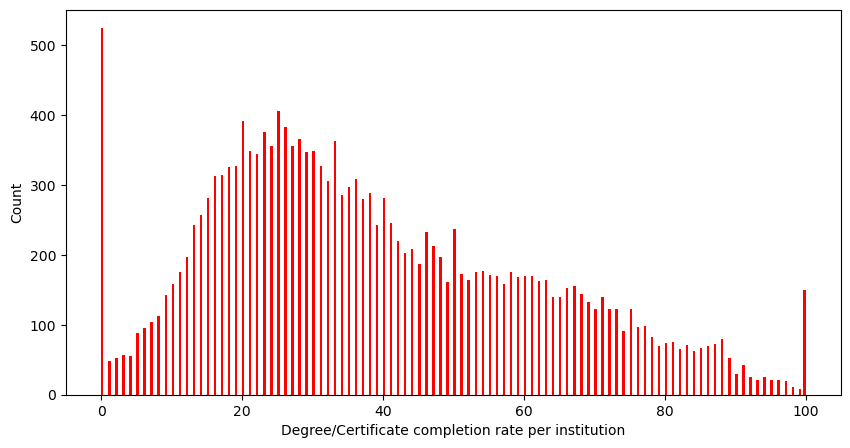

Median completion rate: 34.0%
Mean completion rate: 38.5513900357831%


In [4]:
undergrad_compl = pd.read_csv(
    r'IPEDS_Dataset_Encoded/Outcome Measures/OM_2015-2021_data.csv', sep=',')
data_compl = undergrad_compl[(undergrad_compl.omchrt == 'First-time, full-time entering, Total')]
fig, ax  = plt.subplots(figsize=(10,5))
data_compl['OMAWDP4'.lower()].hist(bins=300, color='red').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Degree/Certificate completion rate per institution')
ax.set_ylabel('Count')
plt.show()
print('Median completion rate: {}%'.format(data_compl[['OMAWDP4'.lower()]].median().values[0]))
print('Mean completion rate: {}%'.format(data_compl[['OMAWDP4'.lower()]].mean().values[0]))

## 3. Tution fees intensity

In [6]:
fees_money_school = pd.read_csv(r'IPEDS_Dataset_Encoded/Institutional Finances/F_F2_1415-1920_data.csv', sep=',')
fees_money_school[['f2d01','unitid']].groupby('unitid').mean()

,f2d01
unitid,
100690,7.365773e+06
100937,1.391152e+07
101073,2.727705e+06
101189,3.440194e+07
101365,7.459146e+06
...,...
495280,2.716200e+04
495314,6.893088e+06
495767,1.739282e+09


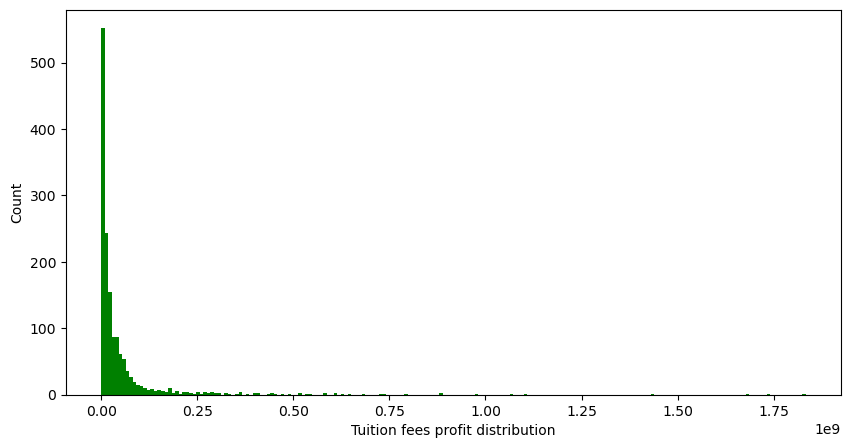

In [7]:
rel_ethn_completion = data_ethn.merge(data_compl[['unitid','OMAWDP4'.lower()]].set_index('unitid'), on='unitid')
rel_ethn_completion = rel_ethn_completion.reset_index().groupby('unitid').mean()

data_without_gpa = rel_ethn_completion.groupby('unitid').first().merge(fees_money_school[['f2d01','unitid']].groupby('unitid').mean(), on='unitid')

stats_df = data_without_gpa.reset_index() \
.groupby('f2d01') \
['f2d01'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'f2d01': 'frequency'})
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
stats_df['cdf'] = stats_df['pdf'].cumsum()

dico_fee = stats_df['cdf'].to_dict()
data_without_gpa['cdf_fee'] = data_without_gpa['f2d01'].map(dico_fee)

fig,ax = plt.subplots(figsize=(10,5))
data_without_gpa['f2d01'].hist(bins=200, color='green').plot()
ax.grid(False)
ax.set_xlabel('Tuition fees profit distribution')
ax.set_ylabel('Count')
plt.show()



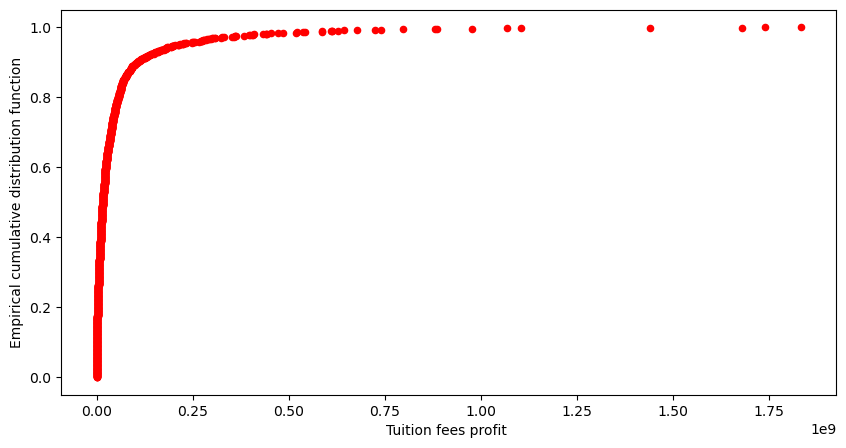

In [8]:
fig,ax = plt.subplots(figsize=(10,5))
data_without_gpa.sort_values(by='cdf_fee').plot.scatter(y='cdf_fee',x='f2d01', ax=ax, color='red')
ax.grid(False)
ax.set_xlabel('Tuition fees profit ')
ax.set_ylabel('Empirical cumulative distribution function')
plt.show()


## 4. Selection rate (approximated by the admission rate)

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


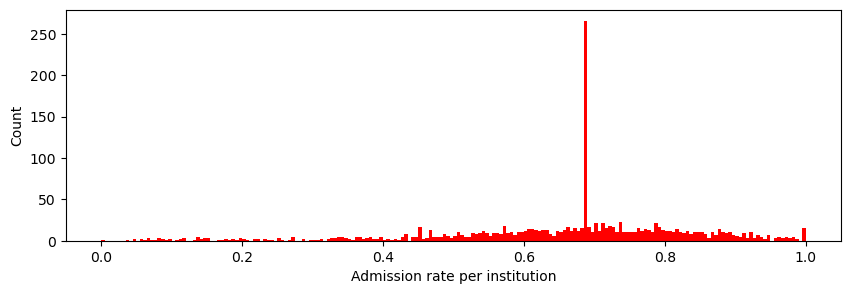

In [9]:
adm_data = pd.read_csv(
    r'IPEDS_Dataset_Encoded/Admission and Test Scores/ADM_2015-2021_data.csv', sep=',')
nb_appl = pd.DataFrame(adm_data.groupby('unitid').sum()['applcn'])['applcn']
nb_adm = pd.DataFrame(adm_data.groupby('unitid').sum()['admssn'])['admssn']
adm_rate = nb_adm/nb_appl
adm_rate_dico = adm_rate.to_dict()

data_with_level = data_without_gpa.reset_index()
data_with_level['level'] = data_with_level['unitid'].map(adm_rate_dico)
data_with_level = data_with_level.fillna(data_with_level['level'].median()) #fill empty values with the median
data_with_level['omawdp4'] /=100

fig,ax = plt.subplots(figsize=(10,3))
data_with_level['level'].hist(bins=200, color='r').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Admission rate per institution')
ax.set_ylabel('Count')
plt.show()

## 5. School quality indicator


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


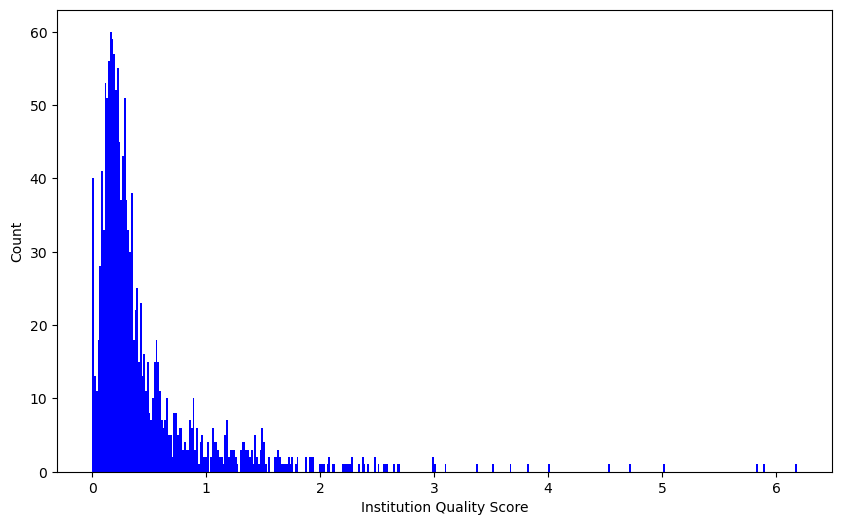

In [146]:
df_final = data_with_level[['unitid', 'kl_distance', 'omawdp4', 'cdf_fee', 'level',
                            'efaiant',	'efasiat',	'efbkaat',	'efhispt',	'efnhpit',	'efwhitt',	'other', 'f2d01']]
df_final['school_quality'] = (df_final['kl_distance']*df_final['omawdp4'])/(df_final['cdf_fee']*df_final['level'])

fig,ax = plt.subplots(figsize=(10,6))
df_final['school_quality'].apply(lambda x: np.log(1+x)).hist(bins=400, color='blue').plot(ax=ax)
ax.grid(False)
ax.set_xlabel('Institution Quality Score')
ax.set_ylabel('Count')
plt.show()

## 6. Model conception: Parametrization through prediction models

### 6.1. Graduation rate model

Determination score: 0.94


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


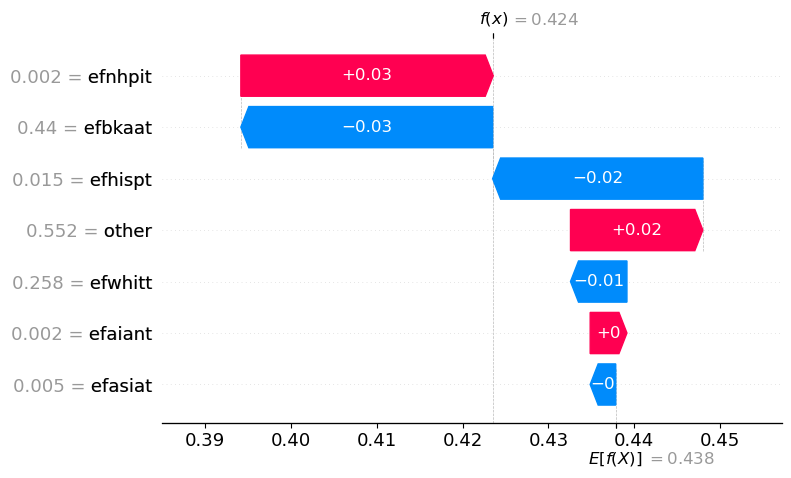

In [11]:
model_grad_rate = xgb.XGBRegressor(objective="reg:squarederror") 

model_grad_rate.fit(np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['omawdp4']))

model_grad_rate_viz = xgb.XGBRegressor(objective="reg:squarederror") 
model_grad_rate_viz.fit(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']], data_with_level['omawdp4'])
print('Determination score: {}'.format(np.round(model_grad_rate_viz.score(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']], data_with_level['omawdp4']),2)))

explainer = shap.Explainer(model_grad_rate_viz)

shap_values = explainer(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']])
shap.plots.waterfall(shap_values[0])

In [12]:
from sklearn.model_selection import train_test_split

X,y=np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['omawdp4'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
model_grad_rate = xgb.XGBRegressor(objective="reg:squarederror" ,max_depth = 5) 

model_grad_rate.fit(X_train, y_train)
print(model_grad_rate.score(X_test, y_test))
                                                    

0.2846745040026508


### 6.2 University level model

Determination score: 0.97


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


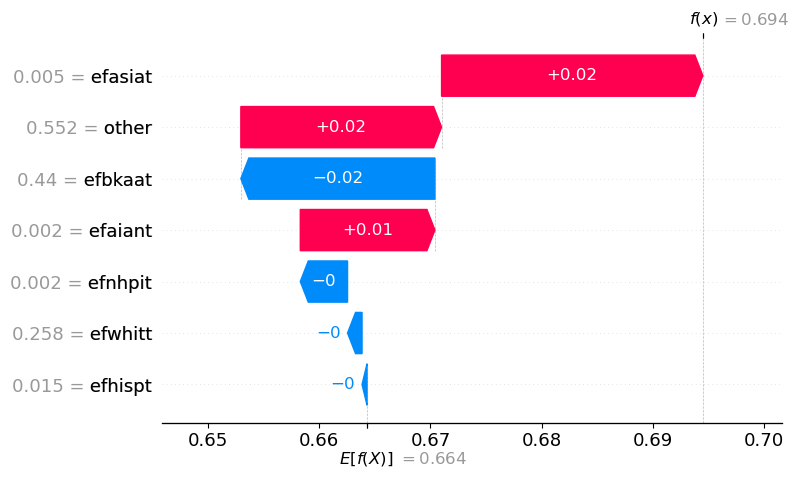

In [13]:
model_level = xgb.XGBRegressor(objective="reg:squarederror") 

model_level.fit(np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['level']))

print('Determination score: {}'.format(np.round(model_level.score(np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['level'])),2)))

model_level_viz = xgb.XGBRegressor(objective="reg:squarederror") 
model_level_viz.fit(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']], data_with_level['level'])

explainer = shap.Explainer(model_level_viz)

shap_values = explainer(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']])

shap.plots.waterfall(shap_values[0])

In [14]:
X,y=np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit',
       'efwhitt', 'other']]), np.array(data_with_level['level'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_level = xgb.XGBRegressor(objective="reg:squarederror" ,max_depth = 5) 

model_level.fit(X_train, y_train)
print(model_level.score(X_test, y_test))
                                                    

0.043550716265142175


## 7. Parametric postsecondary system effectiveness

In [16]:
list_schools = np.array(data_with_level['unitid'])
dico_school_cdf_fee = data_with_level[['unitid','cdf_fee']].set_index('unitid').to_dict()['cdf_fee']
dico_school_level = data_with_level[['unitid','level']].set_index('unitid').to_dict()['level']
dico_school_grad_rate = data_with_level[['unitid','omawdp4']].set_index('unitid').to_dict()['omawdp4']
#omawdp4

def parametric_institution_quality_school(school, p):
    diversity_score = JSD(p)
    #graduation_rate = model_grad_rate.predict([p])[0]
    graduation_rate = dico_school_grad_rate[school]
    fee_cdf = dico_school_cdf_fee[school]
    #admission_rate = model_level.predict([p])[0]
    admission_rate = dico_school_level[school]
    return (diversity_score*graduation_rate)/(fee_cdf*admission_rate)

def parametric_institution_quality(p_list):
    df = data_with_level.copy()
    df[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit','efwhitt', 'other']]=p_list
    df['school_quality']=df[['unitid','efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit','efwhitt', 'other']].apply(
    lambda x: parametric_institution_quality_school(x[0],[x[i] for i in range(1,8)]), axis=1)
    #x[0],[x[i] for i in range(1,8)])
    return df['school_quality'].mean()

def param_quality(p):
    p_list = p.reshape(len(data_with_level),7)
    return -parametric_institution_quality(p_list)

cons = ({'type': 'eq',
         'fun' : lambda x: x[7*i+1]+x[7*i+2]+x[7*i+3]+x[7*i+4]+x[7*i+5]+x[7*i+6] - 1
        } for i in range(len(data_with_level)))


initial_guess = np.ndarray.flatten(
    np.array(data_with_level[['efaiant', 'efasiat', 'efbkaat', 'efhispt', 'efnhpit','efwhitt', 'other']])
                                    )

initial_guess


array([0.00233418, 0.00458423, 0.43961975, ..., 0.00081277, 0.63634542,
       0.08335931])

In [17]:
param_quality(initial_guess)

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
invalid value encountered in double_scalars


-1.9420358912826723

In [ ]:
# from scipy.optimize import minimize

# nb_eval = 1
# def callbackF(x):
#     global nb_eval
#     print(nb_eval, param_quality(x))
#     nb_eval += 1
    
# opt_ethn_prop = minimize(param_quality, initial_guess, constraints = cons, options={'maxiter':5}, callback=callbackF)

#not enough time to optimize!

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
invalid value encountered in double_scalars


In [147]:
df_final

,unitid,kl_distance,omawdp4,cdf_fee,level,efaiant,efasiat,efbkaat,efhispt,efnhpit,efwhitt,other,f2d01,school_quality
0,100690,0.413498,0.416,0.332440,0.689388,0.002334,0.004584,0.439620,0.014845,0.002473,0.258412,0.552461,7.365773e+06,0.750568
1,100937,0.276829,0.590,0.469839,0.562805,0.005209,0.037445,0.128224,0.025553,0.000000,0.785661,0.012541,1.391152e+07,0.617671
2,101073,0.602184,0.010,0.197051,0.379170,0.000000,0.000684,0.919829,0.013478,0.000000,0.034059,0.000000,2.727705e+06,0.080597
3,101189,0.259607,0.168,0.680295,0.580446,0.006158,0.007520,0.413070,0.023536,0.002738,0.491281,0.059137,3.440194e+07,0.110450
4,101365,0.333159,0.498,0.336461,0.902500,0.003711,0.002825,0.577366,0.023394,0.002293,0.310626,0.122652,7.459146e+06,0.546385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,493798,0.472110,0.940,0.126676,0.691108,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.344227e+06,5.069118
1488,494685,0.190477,0.110,0.166220,0.791822,0.022534,0.016558,0.051173,0.159613,0.000000,0.690610,0.057893,2.103659e+06,0.159193
1489,495147,0.364900,0.335,0.016086,0.689388,0.000000,0.025000,0.000000,0.375000,0.000000,0.525000,0.000000,1.720920e+05,11.023323
1490,495280,0.740821,0.345,0.003351,0.689388,0.925000,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,2.716200e+04,110.628641


In [151]:
df_final_sorted = df_final.sort_values('school_quality', ascending=False)
df_final_sorted.head(10)

,unitid,kl_distance,omawdp4,cdf_fee,level,efaiant,efasiat,efbkaat,efhispt,efnhpit,efwhitt,other,f2d01,school_quality
1353,446613,0.668546,1.000000,0.002011,0.689388,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18264.500000,482.297274
907,211149,0.251290,0.816667,0.000670,0.846561,0.000000,0.018365,0.394879,0.022465,0.000000,0.490261,0.148058,0.000000,361.685511
754,197221,0.358953,0.688000,0.002681,0.272523,0.000000,0.095901,0.000000,0.019693,0.000000,0.793448,0.106549,26834.333333,338.012720
618,183600,0.446162,0.936000,0.004021,0.689388,0.000000,0.211301,0.003030,0.034982,0.000000,0.279063,0.021505,43379.666667,150.633726
1490,495280,0.740821,0.345000,0.003351,0.689388,0.925000,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,27162.000000,110.628641
1306,437705,0.672591,0.576667,0.004692,0.894737,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,59258.166667,92.395558
1468,490850,0.599962,0.415000,0.006702,0.689388,0.500000,0.000000,0.227273,0.000000,0.000000,0.272727,0.000000,76339.000000,53.886112
916,211893,0.366375,0.342000,0.072386,0.038903,0.000000,0.176367,0.046137,0.024705,0.000000,0.362545,0.000000,739000.333333,44.495465
1471,491491,0.780581,1.000000,0.047587,0.428571,0.000000,0.430233,0.000000,0.000000,0.000000,0.000000,0.000000,483204.000000,38.274114
602,181543,0.327791,0.390000,0.007373,0.530120,0.004505,0.000000,0.021481,0.064245,0.004902,0.836187,0.056494,78409.500000,32.708652


In [149]:
df_final.sort_values('school_quality', ascending=False).head(10).unitid.values


array([446613, 211149, 197221, 183600, 495280, 437705, 490850, 211893,
       491491, 181543])

In [22]:
#according to https://nces.ed.gov/ipeds/datacenter/InstitutionProfile.aspx, the top 10 schools are:

# UnitID	Name	                                                 
# 183600	Assumption College for Sisters		
# 211893	Curtis Institute of Music		
# 495280	Indian Bible College	Flagstaff	
# 437705	Monteclaro Escuela de Hoteleria y Artes Culinarias	
# 181543	Summit Christian College		
# 446613	W L Bonner College		
# 197221	Webb Institute	 	

#some names are missing as they are not available in the IPEDS database search engine

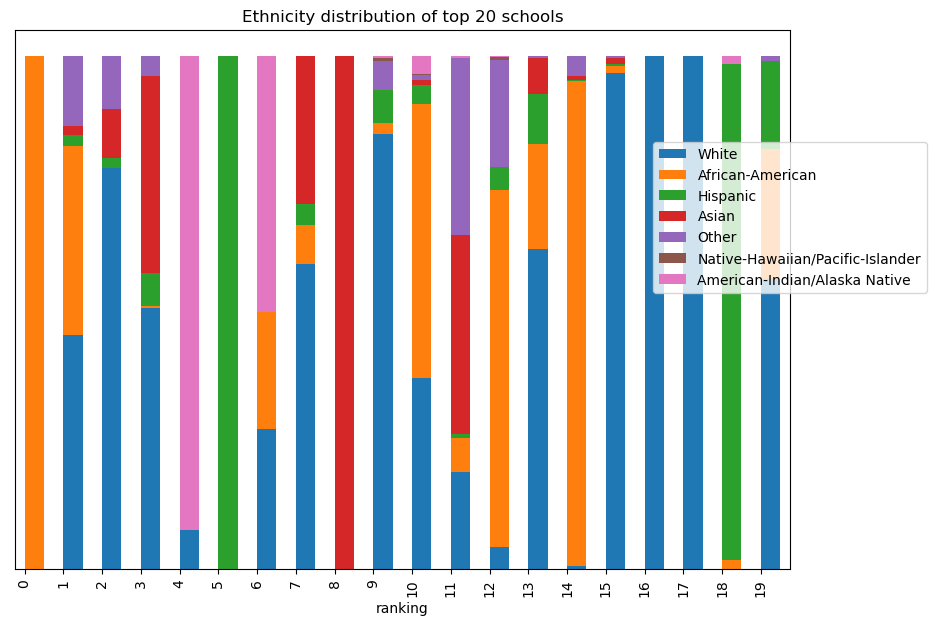

In [184]:
r=20

ethn_list = ['efwhitt', 'efbkaat', 'efhispt', 'efasiat','other', 'efnhpit',  'efaiant']
final_ethn = df_final_sorted[ethn_list].head(r)

#ax =plt.axes()

final_ethn[ethn_list]=final_ethn[ethn_list].div(final_ethn[ethn_list].sum(axis=1), axis=0)
final_ethn=final_ethn.reset_index()
final_ethn.drop(columns=['index'], inplace=True)
final_ethn

ax = final_ethn.head(30).plot(kind='bar', stacked=True,
                              align='edge', figsize=(10, 7), xlabel='ranking')
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(False)
ax.title.set_text(F"Ethnicity distribution of top {r} schools")
ax.legend(['White', 'African-American', 'Hispanic', 'Asian', 'Other',
          'Native-Hawaiian/Pacific-Islander', 'American-Indian/Alaska Native'], loc='lower center', bbox_to_anchor=(1, 0.5))


Text(0.5, 1.0, 'Tuition Fee for the top 600 schools')

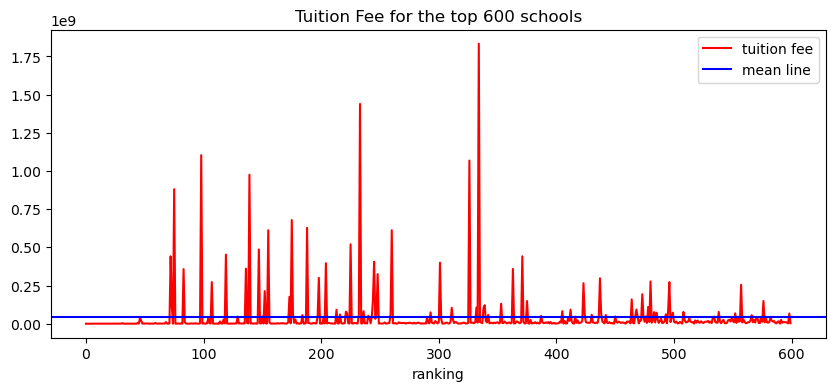

In [159]:
r=600
final_tuifee = df_final_sorted[['unitid', 'f2d01']].head(r)

final_tuifee.reset_index(drop=True, inplace=True)
#final_tuifee
# final_tuifee.plot(y='f2d01', kind='bar', figsize=(20, 4), label = 'tuition fee', xlabel='ranking')

#plot final_tuifee with bar and regression line
plt.figure(figsize=(10, 4))
plt.plot(final_tuifee['f2d01'], color='red', label='tuition fee',)
#plot mean line for final_tuifee        
plt.axhline(final_tuifee['f2d01'].mean(), color='blue', label='mean line')
plt.legend()
plt.xlabel('ranking')

# #kde plot
# final_tuifee.plot(y='f2d01', kind='hist', figsize=(20, 4), label = 'tuition fee', xlabel='ranking')
plt.title(F"Tuition Fee for the top {r} schools")


Text(0.5, 1.0, 'Graduation rate for the top 200 schools')

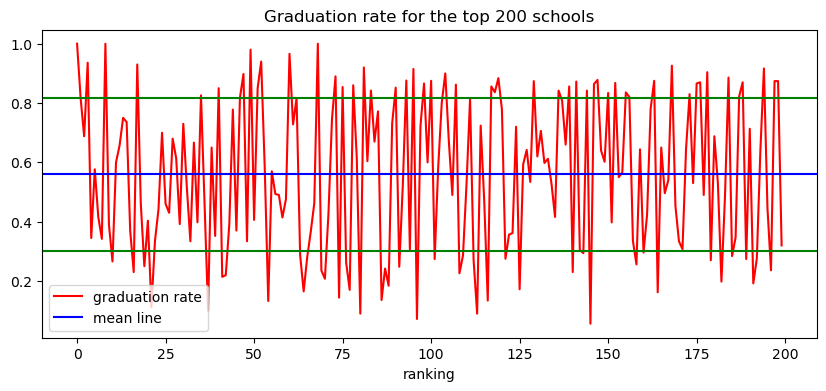

In [160]:
r=200
final_selection = df_final_sorted[['unitid', 'omawdp4']].head(r)
final_selection.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 4))
plt.plot(final_selection['omawdp4'], color='red', label='graduation rate')

#plot mean line for final_selection        
plt.axhline(final_selection['omawdp4'].mean(), color='blue', label='mean line')
plt.axhline(final_selection['omawdp4'].mean()-final_selection['omawdp4'].std(), color='green', )
plt.axhline(final_selection['omawdp4'].mean()+final_selection['omawdp4'].std(), color='green', )
plt.title('')
plt.legend()
plt.xlabel('ranking')
plt.title(F"Graduation rate for the top {r} schools")



Text(0.5, 1.0, 'Selection rate for the top 900 schools')

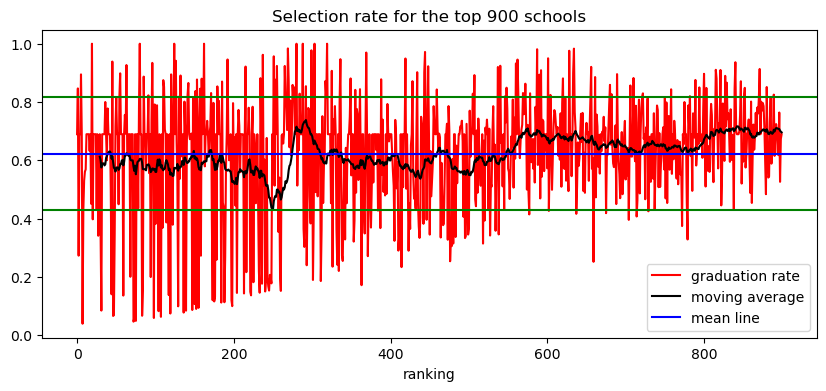

In [172]:
r=900
final_select = df_final_sorted[['unitid', 'level']].head(r)
final_select.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 4))
plt.plot(final_select['level'], color='red', label='graduation rate')
plt.plot(final_select['level'].rolling(30).mean(), color='black', label='moving average')

#plot mean line for final_select        
plt.axhline(final_select['level'].mean(), color='blue', label='mean line')
plt.axhline(final_select['level'].mean()-final_select['level'].std(), color='green', )
plt.axhline(final_select['level'].mean()+final_select['level'].std(), color='green', )
plt.title('')
plt.legend()
plt.xlabel('ranking')

plt.title(F"Selection rate for the top {r} schools")